# Part II - Explanatory Data Analysis for Prosper Loan data
## by Opetunde Adepoju

## Investigation Overview


In this notebook, I wanted to find out which features were the best indicators for predicting the highest rate of return.

In the univariate exploration, I visualized and addressed minor quality and tidiness issues for the following features:

### Numerical Features
1. Estimated Returns
2. Actual Returns
3. Debt to Income Ratio

### Categorical Features
1. Income Range
2. Credit Grade
The Actual Returns for the dataset was engineered from a simplified version of Prosper's Net Annualized formula.

The bivariate exploration revealed the numerical categories did not have any obvious correlations. When comparing the estimated returns with the income range and credit grade, it became apparent that the credit grade is a much better predictor for returns than the income range. The credit grade spanned every income range, however I noticed that borrowers with higher incomes often received better credit ratings.

The multivariate exploration revealed again that the credit rating was the best primary predictor for estimated returns. When introducing the loan status, loans that have been completed or are current followed a linear correlation between estimated and actual returns.

## Dataset Overview

Prosper is a P2P lending platform that allows investors to choose among personal loans to invest in. They do that by considering a number of factors, which include a custom calculated Prosper Score that represents the risk for each loan. The higher the score, the lower the risk, and the lower the interest rates paid by the borrower to the investors.

This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
the_loan = pd.read_csv('prosperLoanData.csv')
loan = the_loan.copy()

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Finding Actual Returns

To simplify our calculation for exploratory purposes, we will only divide by the original loan amount. We will run into other categorical issues if we try to determine the current rate of return for current loans vs completed loans etc. We may revisit this section to refine our actual returns feature.


There are some loans where it appears that the borrower never made a payment which gives us the minimum of losing 100% of the investment. On the other end of the spectrum, it looks like most loans drop off after about 170% of the original loan amount.

There appears to be different modes to the distribution. I will check to see how the actual returns are different from the loan status.

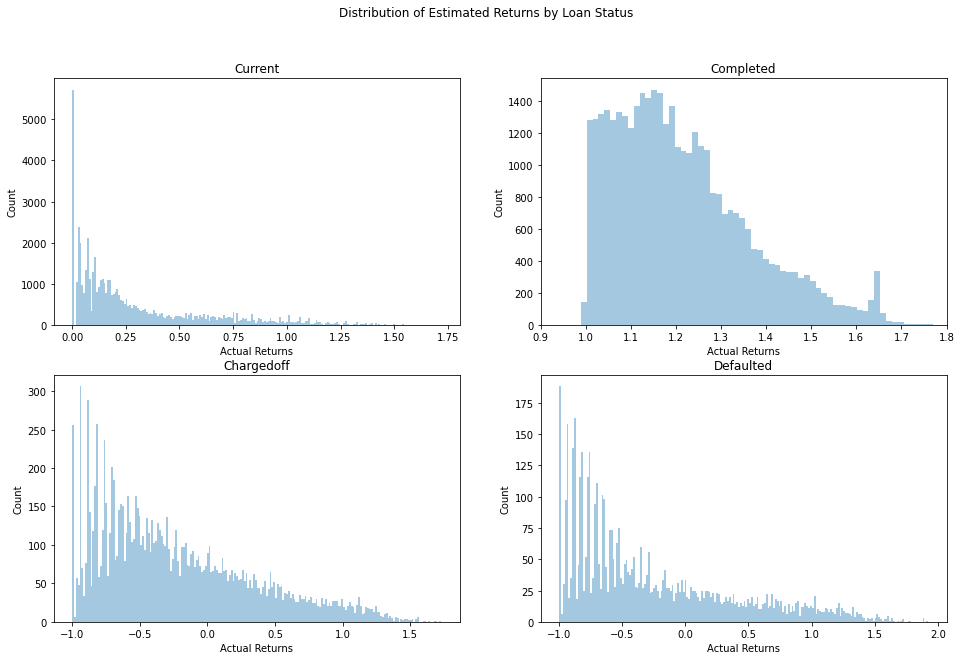

In [4]:
loan['ActualReturns'] = loan.LP_CustomerPayments - loan.LoanOriginalAmount - (loan.LP_ServiceFees + loan.LP_CollectionFees + loan.LP_NetPrincipalLoss)
loan['ActualReturns'] = 1 + (loan.ActualReturns / loan.LoanOriginalAmount)
# multiplot for loan status

variables = ['Current', 'Completed', 'Chargedoff', 'Defaulted']

plt.figure(figsize = [16, 10])

# loop through variables list
for i in range(len(variables)):
    plt.subplot(2, 2, i+1)
    
    sb.distplot(loan.query('LoanStatus == "{}"'.format(variables[i])).ActualReturns, 
                 kde = False, bins = 200)
    
    plt.xlabel('Actual Returns')
    plt.ylabel('Count')
    plt.title(variables[i])
    
plt.subplot(2, 2, 2)
plt.xlim(.9, 1.8)

plt.suptitle('Distribution of Estimated Returns by Loan Status');

## Visualizing Prosper rating with credit grade

From the feature descriptions, it looks like Prosper transitioned to a "Prosper Rating" after 2009 to differentiate themselves from the industry standard "Credit Grade.

For exploratory purposes, we'll replace the Credit Grade of No Credit (NC) with High Risk (HR) and combine this column with the Prosper Rating.

In the future we may want to look at estimated returns of the pre-2009 "Credit Grade" to see how it compares with the post-2009 "Prosper Rating" to validate if they truly are equivalent or if Prosper skewed their credit rating in some way.

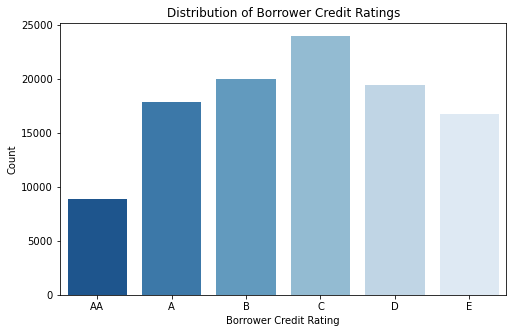

In [5]:
# replace NC with HR
loan['CreditGrade'].replace(['NC', 'HR'], 'E', inplace = True)

# fill NA with empty strings
loan['ProsperRating (Alpha)'].fillna("", inplace = True)
loan['CreditGrade'].fillna("", inplace = True)

# combine credit ratings
loan['ProsperRatingCombined'] = loan['ProsperRating (Alpha)'] + loan['CreditGrade']

# drop rows with no credit ratings
loan = loan.query(' ProsperRatingCombined != ""')

# convert string to ordinal category type
ordinal_rating = ['AA', 'A', 'B', 'C', 'D', 'E']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_rating)
loan['ProsperRatingCombined'] = loan['ProsperRatingCombined'].astype(ordered_var)

plt.figure(figsize = [8, 5])
sb.countplot(data = loan, x = 'ProsperRatingCombined', palette = "Blues_r")
plt.xlabel('Borrower Credit Rating')
plt.ylabel('Count')
plt.title('Distribution of Borrower Credit Ratings');

## Visualizing Income Range Analysis

There are a couple of features that are required for borrowers to be assigned these Credit Ratings. We'll start with taking a look at Income Ranges.

From the visualization, we can deduce from here that the number of borrowers for the `$25k-49k` range is the same as the `$50k - 74k` range. The amount of borrowers in the `$74k` range. The amount of borrowers in the `$75k-100k` range is the same as all the borrowers that have an income of over 100k.

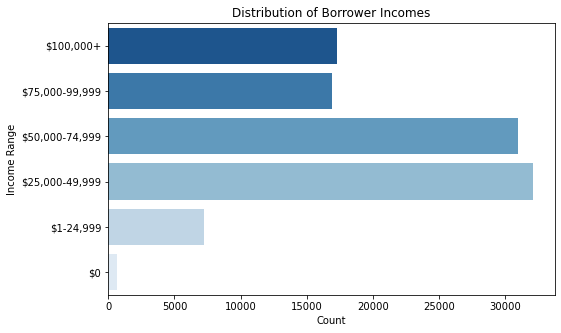

In [6]:
# create ordinal categories for income
ordinal_rating = ['$100,000+', '$75,000-99,999', '$50,000-74,999', '$25,000-49,999', '$1-24,999', '$0']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_rating)
loan['IncomeRange'] = loan['IncomeRange'].astype(ordered_var)

# bar chart
plt.figure(figsize = [8, 5])
sb.countplot(data = loan, y = 'IncomeRange', palette = "Blues_r")
plt.ylabel('Income Range')
plt.xlabel('Count')
plt.title('Distribution of Borrower Incomes');

## Debt to Income Ratio

Of course your income is only part of the picture, let's see what the borrower's Debt to Income Ratio is like. I imagine a creditor wants to make sure you're not overleveraged in the event you have a loss of income and are unable to repay all of your debts. This will help us determine the distribution of their credit score.

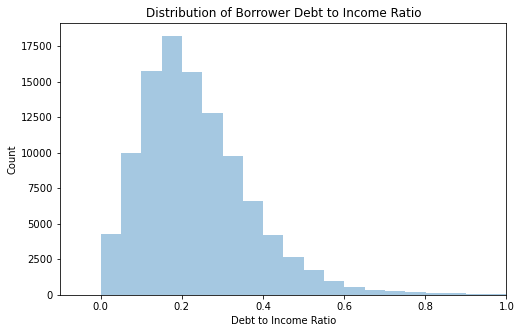

In [7]:
# distribution plot
plt.figure(figsize = [8,5])
sb.distplot(loan.DebtToIncomeRatio, kde = False, bins = 200)
plt.xlim(-.1, 1)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Count')
plt.title('Distribution of Borrower Debt to Income Ratio');

To summarize our variables of interest, we looked at income, debt to income ratios, credit ratings, estimated returns and actual returns for the data set.

We saw relatively normal distributions for income, debt to income, credit ratings, and estimated returns. However, trying to calculate the real time actual returns proved to be difficult. We may want to revisit this feature if we are trying to answer a particular question about the data set.

While doing some research for this dataset, I stumbled across a few blog posts discussing how Prosper has updated how they calculate their annualized returns resulting in lower returns.


## Income range vs credit rating analysis

We can intuitively expect borrowers with a high debt to income ratio to be riskier and thus have a lower rate of return - but that doesn't seem to be the case.

Let's take a look at how a borrower's income range and credit rating relates to the investor's estimated returns.

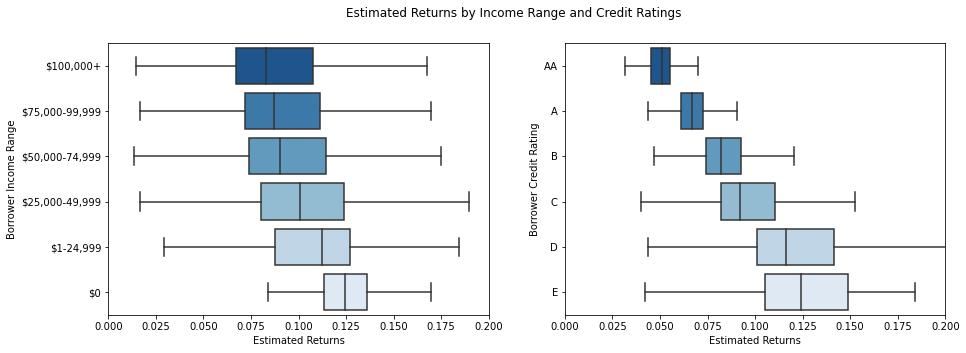

In [8]:
# boxplots
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
base_color = sb.color_palette()[0]
sb.boxplot(data = loan, y = 'IncomeRange', x = 'EstimatedReturn', palette = "Blues_r", showfliers = False)
plt.xlim(0,.2)
plt.ylabel('Borrower Income Range')
plt.xlabel('Estimated Returns')

plt.subplot(1, 2, 2)
base_color = sb.color_palette()[0]
sb.boxplot(data = loan, y = 'ProsperRatingCombined', x = 'EstimatedReturn', palette = "Blues_r", showfliers = False)
plt.xlim(0,.2)
plt.ylabel('Borrower Credit Rating')
plt.xlabel('Estimated Returns')

plt.suptitle('Estimated Returns by Income Range and Credit Ratings');

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [10]:
!jupyter nbconvert Slide_deck_Explanatory_Data_Analysis.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Slide_deck_Explanatory_Data_Analysis.ipynb to slides
[NbConvertApp] Writing 691441 bytes to Slide_deck_Explanatory_Data_Analysis.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\Opetunde Adepoju\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\Opetunde Adepoju\anaconda3\lib\site-packages\jupyter_core\application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\Opetunde Adepoju\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\Opetunde Adepoju\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 369, in start
    self.convert_notebooks()
  File "C:\Users\Opetunde Adepoju\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", 

> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 